# [IAPR 2019:][iapr2019] Lab 1 ‒  Image segmentation

**Author:** Zhaodong Sun, Shengzhao Xia  
**Due date:** 04.04.2019

[iapr2019]: https://github.com/LTS5/iapr-2019

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

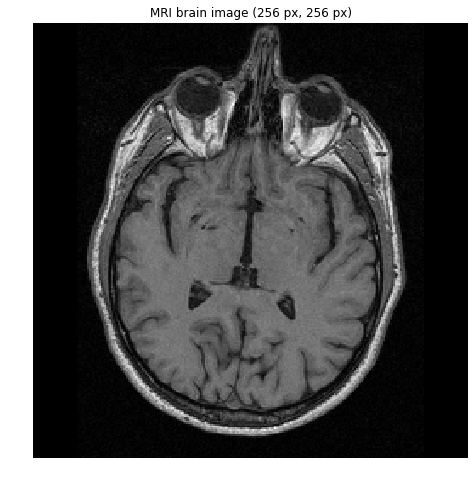

In [2]:
import skimage.io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from scipy import ndimage as ndi

from skimage.morphology import watershed
from skimage.feature import peak_local_max
import sys
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing
Add your implementation and discussion

### Preprocess the image

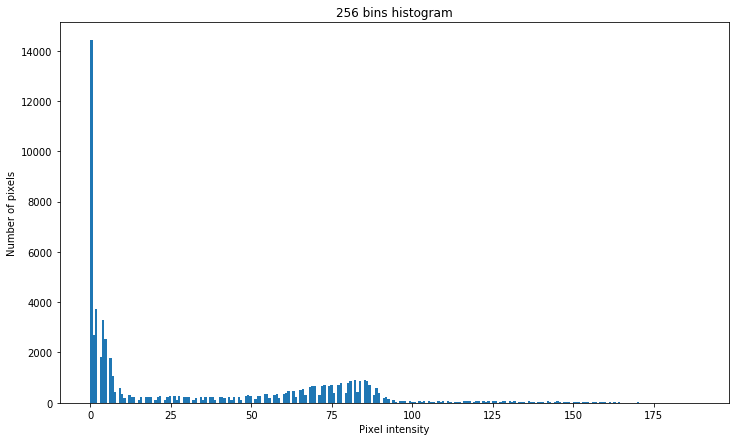

In [3]:
nb_bins = 256
# Display histogram
plt.figure(figsize=(12, 7))
plt.hist(brain_im.ravel(), bins=nb_bins)
plt.xlabel('Pixel intensity')
plt.ylabel('Number of pixels')
plt.title('256 bins histogram')
plt.show()

#### Threshold the image

From the histogram above, we can see the pixels are around two parts, which are 0-10, and 50-90. The pixels whoses intensities are between 50-90 are the brain including the skull while the 0-10 part are some noise in the image. Therefore, we threshold the image to keep the pixel between 50-90.

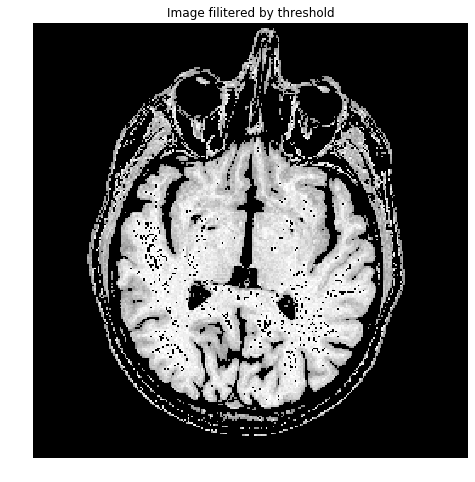

In [4]:
brain_im_temp = brain_im.copy()
plt.figure(figsize=(16, 8))
brain_im_temp[np.logical_or(brain_im<50, brain_im>90)] = 0
plt.imshow(brain_im_temp, cmap='gray')
plt.title('Image filitered by threshold')
plt.axis('off')
plt.show()

#### Use opening to remove the skull

However, the skull is still in the image and we need to remove it as much as possible. So we can use opening to remove eyes and the skull. The pre-processed image is shown below. Some pixels of the skull are removed and this image will be convenient for us to extract the brain.

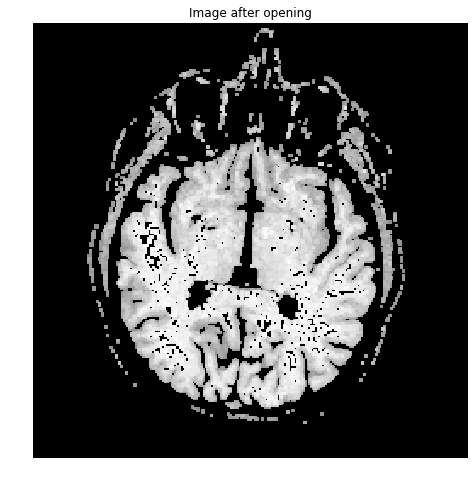

In [5]:
plt.figure(figsize=(16, 8))
import skimage.morphology as morph
brain_opening = morph.opening(brain_im_temp, np.ones((2,2)))
plt.imshow(brain_opening, cmap='gray')
plt.title('Image after opening')
plt.axis('off')
plt.show()

### Implementation of region growing

The following class is our implementation of region growing. We find each homogeneous regions recursively. Each time the region spreads, we will check if the new adjacent pixel can satisfy our homogeneous condition. If yes, the new pixel will be added to this region. Once the homogeneous condition cannot be satisfied, the program will stop the recursive search.

In [6]:
class RegionGrow:
    def __init__(self, pic, threshold):
        '''
            Initialize.
        '''
        self.pic = pic
        # Homogeneity criterion: use threshold to extract
        self.threshold = threshold
        # Used to store cordinates in the region and cordinates have been searched
        self._region = set()
        self._region_list = []
        self._searched = set() 
        self._all_point = set([(i, j) for i in range(pic.shape[0]) for j in range(pic.shape[1])])
        # 4-connectivity of pixels
        self._delta_x_list, self._delta_y_list = [0, 0, -1, 1], [-1, 1, 0, 0]
        # Increase the capacity of the stack
        MAXCAPACITY = int(1e6)
        sys.setrecursionlimit(MAXCAPACITY)
            
    def find_region(self, cord, lt, ht):
        '''
            Recursively find region.
        '''
        # 4-connectivity window of an aimed pixel
        window = zip(self._delta_x_list, self._delta_y_list)
        # Add the pixel to searched list
        self._searched.add(cord)
        if self.pic[cord] <= ht and self.pic[cord] >= lt and cord not in self._region:
            # If the pixel is in region
            self._region.add(cord)
        else:
            return 
        for delta_x, delta_y in window:
            if (cord[0]+delta_x, cord[1]+delta_y) not in self._searched and \
                cord[0]+delta_x < self.pic.shape[0] and cord[1]+delta_y < self.pic.shape[1] and \
                cord[0]+delta_x >= 0 and cord[1]+delta_y >= 0:
                val = self.pic[cord]
                lt, ht = val - self.threshold, val + self.threshold
                self.find_region((cord[0]+delta_x, cord[1]+delta_y), lt, ht)
    
    def find_regions(self):
        '''
            Region growing and find all connected conmponent.
        '''
        while self._all_point.difference(self._searched):
            self._region = set()
            diff_list = list(self._all_point.difference(self._searched))
            seed = diff_list[np.random.choice(len(diff_list))]
            self.find_region(seed, self.pic[seed], self.pic[seed])
            self._region_list.append(self._region)
            
    def find_ith_component(self, ith_component):
            '''
                Find ith largest component of pic.
            '''
            # Show the results
            len_list = [len(region) for region in self._region_list]
            region_sorted = np.sort(len_list)[::-1]
            return np.array(self._region_list)[np.where(len_list==region_sorted[ith_component])]

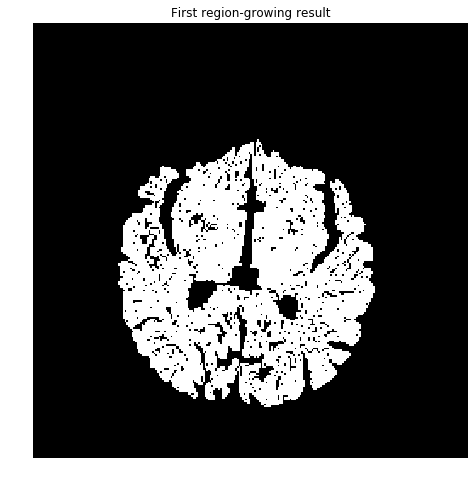

In [7]:
a = RegionGrow(brain_opening, 10)
a.find_regions()
# Show the results
ith_component = 1
img_rg = np.zeros_like(brain_opening)
for region in a.find_ith_component(ith_component):
    for pixel in region:
        img_rg[pixel] = 255.0
plt.figure(figsize=(16, 8))
plt.imshow(img_rg, cmap='gray')
plt.title('First region-growing result')
plt.axis('off')
plt.show()

After doing region growing and extracting the brain part, there are some small holes on the brain and the segmentaion is not perfect, so we do a second region growing on the segmentaion above. Since these small holes can still satisfy the homogeneous condition, these hole will be filled and we can get a better segmentaion as followings.

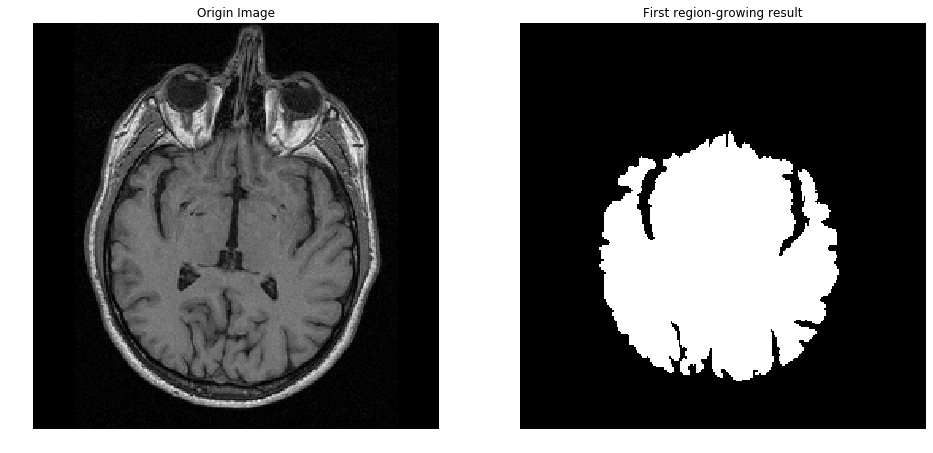

The size of the brain gotten by Roberts Operator edge extraction is 16699 pixels.


In [9]:
pic = img_rg.copy()
b = RegionGrow(img_rg.copy(), 5)
b.find_regions()
ith_component = 0

img_rg_1 = np.ones_like(img_rg)
for region in b.find_ith_component(ith_component):
    for pixel in region:
        img_rg_1[pixel] = 0
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title('Origin Image')
plt.axis('off')
plt.imshow(brain_im, plt.cm.gray)

plt.subplot(122)
plt.imshow(img_rg_1, cmap='gray')
plt.title('Second region-growing result')
plt.axis('off')
plt.show()

print("The size of the brain gotten by Roberts Operator edge extraction is {} pixels.".format(np.sum(img_rg_1)))

### 1.3 Contour detection
Add your implementation and discussion

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import feature
from skimage.filters import roberts, sobel, scharr, prewitt, laplace

First, we tried different operators to detect edges and the results are shown below.

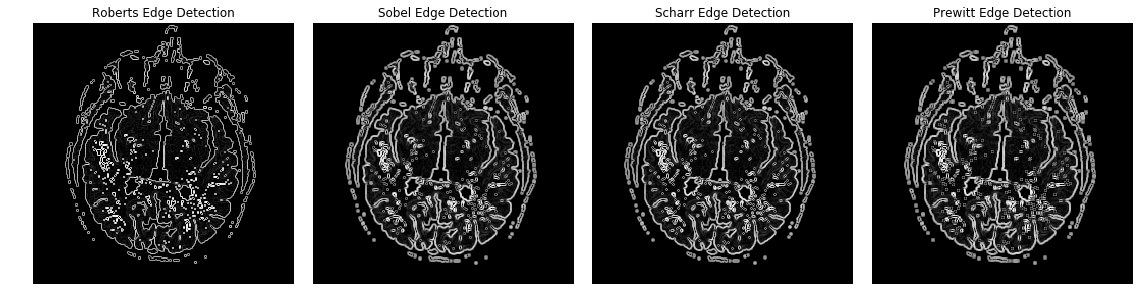

In [11]:
# Try different contour detection methods: different operator
edge_name_list = ['roberts', 'sobel', 'scharr', 'prewitt']
edge_val_list = [roberts(brain_opening), 
                 sobel(brain_opening), 
                 scharr(brain_opening), 
                 prewitt(brain_opening)]

fig, axes = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(16, 8))

for i, ax in enumerate(axes):
    ax.imshow(edge_val_list[i], cmap=plt.cm.gray)
    ax.set_title('{} Edge Detection'.format(edge_name_list[i].capitalize()))
    ax.axis('off')

plt.tight_layout()
plt.show()

Since there are many edges in an image, we can find the largest contour to filter out other short edges. The longest edge corresponds to the brain. As we can see in the following images, the edge produced by Robert operator works best.

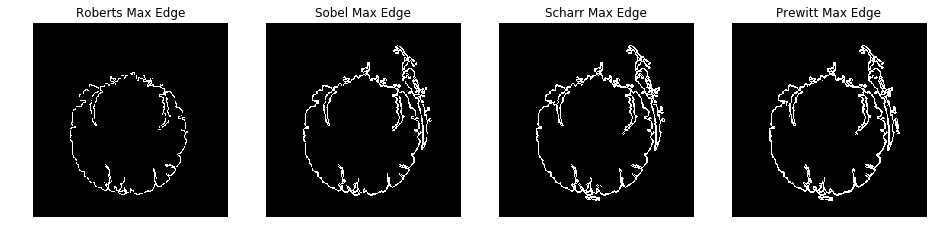

In [12]:
# -------------------- Find the larges contour as the contour of brain -------------------- #
# Here, we have tured the best thresholds for results
threshold_list = [0.1, 0.115, 0.1, 0.1]
fig, axes = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(16, 8))
brain_contour_list = []

for i, ax in enumerate(axes):
    label_img = skimage.measure.label(edge_val_list[i]>threshold_list[i])
#     label_img = morph.opening(label_img)
    # Use label function to get maximum region
    regions=skimage.measure.regionprops(label_img)
    areas = np.array([region.area for region in regions])
    sort_list = np.argsort(areas)[::-1]
    
    temp = np.full_like(label_img, False)
    for coord in regions[sort_list[0]].coords:
        temp[coord[0]][coord[1]]=True
    brain_contour_list.append(temp)
    
    ax.imshow(temp, cmap=plt.cm.gray)
    ax.set_title('{} Max Edge'.format(edge_name_list[i].capitalize()))
    ax.axis('off')

In order to get the size of the brain, we need to fill the region surrounded by the edge. The function `ndi.binary_fill_holes` can be used to fill the pixels inside the contour.

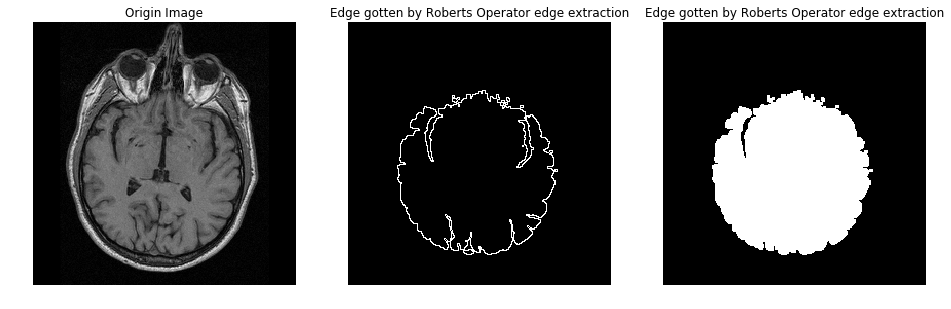

The size of the brain gotten by Roberts Operator edge extraction is 18726 pixels.


In [13]:
# Roberts Operator has the best result, output the size of the brain (in pixels)
plt.figure(figsize=(16, 8))
plt.subplot(131)
plt.title('Origin Image')
plt.axis('off')
plt.imshow(brain_im, plt.cm.gray)

plt.subplot(132)
plt.title('Edge gotten by Roberts Operator edge extraction')
plt.axis('off')
plt.imshow(brain_contour_list[0], plt.cm.gray)

plt.subplot(133)
plt.title('Edge gotten by Roberts Operator edge extraction')
plt.axis('off')
fill_coins = ndi.binary_fill_holes(brain_contour_list[0])
plt.imshow(fill_coins, cmap=plt.cm.gray)
plt.show()
print("The size of the brain gotten by Roberts Operator edge extraction is {} pixels.".format(np.sum(fill_coins)))

We also tried Canny operator to do segmentaion and the procedures are the same as above

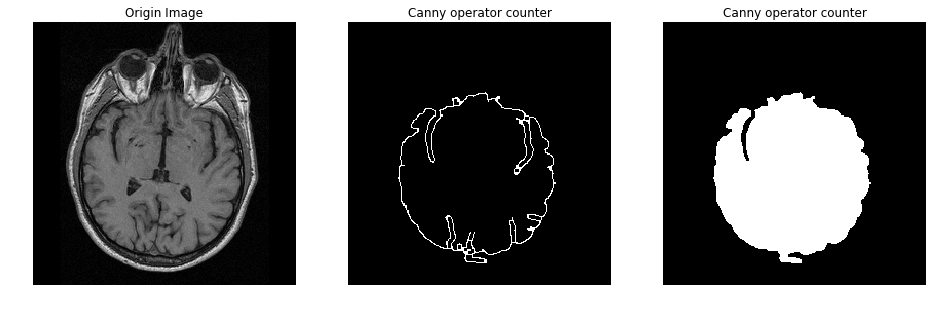

The size of the brain gotten by Roberts Operator edge extraction is 18452 pixels.


In [14]:
# -------------------- Try canny operator as below -------------------- #
plt.figure(figsize=(16, 8))

plt.subplot(131)
plt.title('Origin Image')
plt.axis('off')
plt.imshow(brain_im, plt.cm.gray)

plt.subplot(132)
edges2 = feature.canny(brain_opening, sigma=2)
edges2 = morph.closing(edges2, np.ones([3,3]))
label_img = skimage.measure.label(edges2)
# Use label function to get maximum region
regions=skimage.measure.regionprops(label_img)
areas = np.array([region.area for region in regions])
sort_list = np.argsort(areas)[::-1]

temp = np.full_like(label_img, False)
for coord in regions[sort_list[0]].coords:
    temp[coord[0]][coord[1]]=True
plt.imshow(temp, cmap=plt.cm.gray)
plt.title('Canny operator counter')
plt.axis('off')
    
plt.subplot(133)
fill_coins = ndi.binary_fill_holes(temp)
plt.imshow(fill_coins, cmap=plt.cm.gray)
plt.title('Canny operator counter')
plt.axis('off')
plt.show()
print("The size of the brain gotten by Roberts Operator edge extraction is {} pixels.".format(np.sum(fill_coins)))

### 1.4 Additional method(s)
Add your implementation and discussion

#### Watershed Algorithm

We also use watershed algorithm to get the segmentation of the brain. First, we obtain the distance map for the pre-processed image. Then we get the local maxima in 235 by 235 windows. This parameters need to be tuned to get the good result. We use the watershed function to get the segmentation. The distance needs to be minus since we need to get some basins and the watershed algorithm needs to find watershed basins in image flooded from given local minima(which is also the maximum in the original distance map).

The size of the brain is 15870


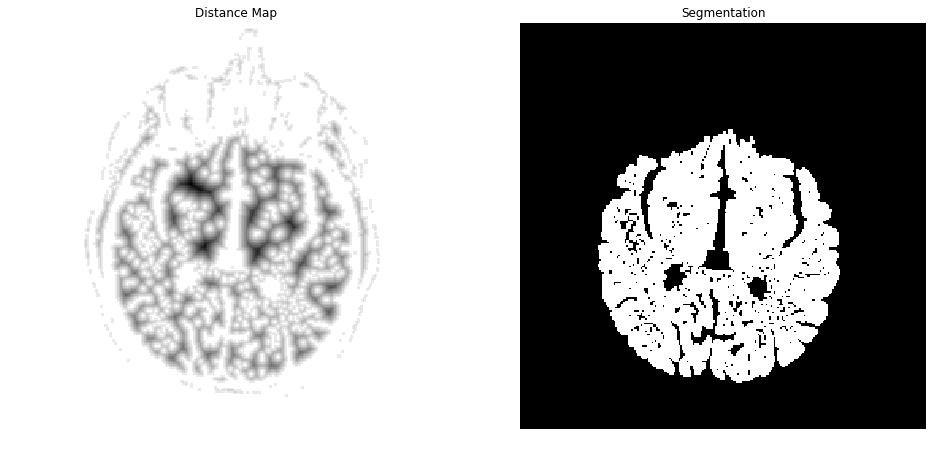

In [15]:
image = brain_opening

distance = ndi.distance_transform_edt(image) # get the distance map, which is the distance between the foreground pixel and background pixel
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((235, 235)),
                            labels=image) # find the local maxima on the distance map
markers = ndi.label(local_maxi)[0] # label all the maxima
labels = watershed(-distance, markers, mask=(image>0)) # use the watershed algorithm to get the segmentation map
# the input distance has a minus, which can produce basins, since the watershed algorithm needs to find watershed basins in image flooded from given markers

fig, axes = plt.subplots(ncols=2, figsize=(16, 8), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(-distance, cmap='gray')
ax[0].set_title('Distance Map')
ax[1].imshow(labels, cmap='gray')
ax[1].set_title('Segmentation')

for a in ax:
    a.set_axis_off()
print('The size of the brain is %d'%(np.sum(labels)))

#### Find the largest connected region

We first use  `skimage.measure.label` to get connected regions on the binarized pre-processed image. Then we calculate the size of each region except for the background and find the region with largest size. Since the brain has the largest size among all the connected regions, we can use this feature to extract the brain.

The size of the brain is 15876


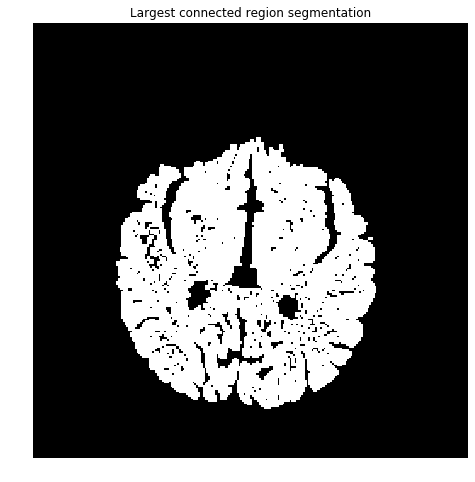

In [19]:
brain_b = (brain_opening>0)
brain_label = skimage.measure.label(brain_b) # label all the connected regions
region_size = 0
largest_region_idx = 0
for i in np.delete(np.unique(brain_label),0): # iterate over all the labels except the background
    if np.sum(brain_label==i)>region_size: # if the size of the new connected area is larger than the current one.
        region_size = np.sum(brain_label==i) 
        largest_region_idx = i # record the size and index of the largest connected region
print('The size of the brain is %d'%(region_size))
plt.figure(figsize=(16, 8))
plt.imshow(brain_label==largest_region_idx, cmap='gray')
plt.title('Largest connected region segmentation')
plt.axis('off')
plt.show()

## Part 2: Save the bees !

Varroa mites are recognized as the biggest pest to honey bees worldwide, and are believed to be the single largest contributing factor in the modern-day decline of honey bees due to their ability to transmit diseases, resulting in death or severe deformity of the pupae. 

Detecting and quantifying the presence of Verroa in a beehive is therefore crucial to treat the infection appropriately and as early as possible, and image analysis appears very useful in this problem.

![Varroa Mite](https://lts5www.epfl.ch/wp-content/uploads/2018/07/varroa-2.jpg)



### 2.1 Introduction to Project

You will find hereafter a set of 4 images taken under real conditions. In this task you will be ask to:
1. Count the number of Varroa on each picture
2. Determine the Intersection over Union of the detected patterns w.r.t. the ground truth
3. Estimate the Precision, Recall and F1-score at two different IoU thresholds $T = {0.5 \text{, and } 0.9}$


**Note** 

Try to have the same routine(s) running on the four images, and giving (approximatively) the same results. The routine(s) that you will write for this part will be useful for the final project as well, so pay special attention to it.

#### Vocabulary


* **IoU**: Let $A$ be the ground truth area and $B$ the predicted one. the intersection over union (IoU) is given as:
$$IoU(A,B) = \frac{A \cap B}{A \cup B} = \frac{\text{Area of Overlap}}{\text{Area of Union}}$$
Let $T$ be a scalar in the interval $[0, 1]$, then $B$ will be considered as a true positive (TP) if and only if $IoU(A,B) \ge T$. As a results, we can evaluate the performance of our detection with different values of $T$. The larger $T$ is, the more constraining is our condition.


* **Precision**: The precision is given as:
$$precision = \frac{tp}{tp + fp}$$
where $tp$ is the number of true positives and $fp$ the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.


* **Recall**: The recall is given as:
$$precision = \frac{tp}{tp + fn}$$
where $tp$ is the number of true positives and $fn$ the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.


* **F1-score**: The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:
$$F1 = \frac{2 \cdot precision \cdot recall}{precision + recall}$$


**FAQ**

Q: What to do if I have multiple ground truth $A_i$ and candidates $B_j$ and want to find the best set $(i,j)$ such that $(i, j) = \arg\max_{i,j} IoU(A_i, B_j)$ ? 

A: Here, we recommend to use a brute force approach. It corresponds to compute $IoU(A, B)$ for every possible pairs (i,j) and keep the pair with the highest $IoU$. Note that a candidate $B_j$ can **only** be matched to **one** ground truth area $A_i$.

Here, we visualize the 4 images for our patern detection

In [20]:
# Load images
im_names = ['varroa-01', 'varroa-02', 'varroa-03', 'varroa-04']
filenames = [os.path.join(data_path, name) + '.jpg' for name in im_names]
ic = skimage.io.imread_collection(filenames)
print('Number of images: ', len(ic))

Number of images:  4


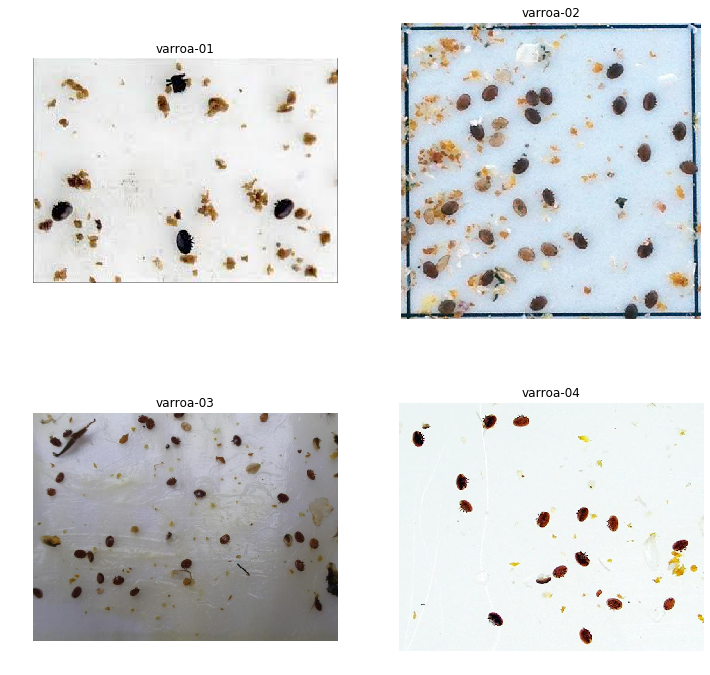

In [21]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), ic, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

We can as well add the groud truth label that are stored in the corresponding XML files. Each xml file stores the position of the varroa on the image as :

```xml
<annotation>
	<object>
		<name>Varroa</name>
		<difficult>0</difficult>
		<bndbox>
			<xmin>14</xmin>
			<ymin>117</ymin>
			<xmax>33</xmax>
			<ymax>137</ymax>
		</bndbox>
	</object>
	<object>
		...
	</object>
	...
</annotation>
```
The block `object` defines the attributes of the varroa. `name` is the definition of the object class (always varroa). `bndbox` is the definition of the bounding box. To simplify your task, we implemented a function named `parse_file` that returns an array with the bounding box of the varroa expressed as `(x, y, width, heigth)` which corresponds to `(xmin, ymin, xmax-xmin, ymax-ymin)`

In [22]:
import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [23]:
annotations_xmls = [parse_file(os.path.join(data_path, name) + '.xml') for name in im_names]

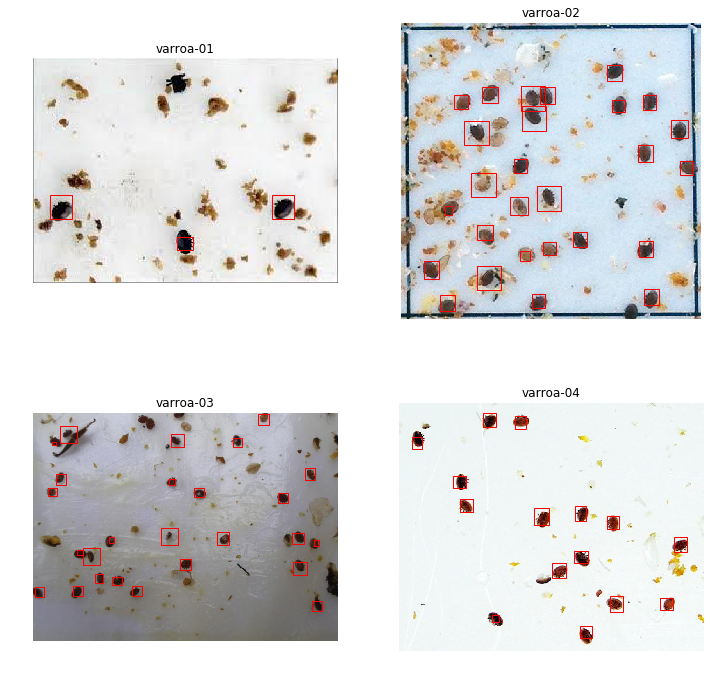

In [24]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm, annotations in zip(axes.ravel(), ic, im_names, annotations_xmls):
    # Iterate over annotations
    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Count the number of Varroa on each picture

Add your implementation and discussion

Hint: `skimage.measure.label` might be useful to label the thresholded image

We first convert the RGB image to grayscale image and use a threshold to binarize the image. However, the images still have some very small areas. Opening can fill the holes outside the large areas,so we can remove these small areas and only keep large areas. Finally, we use the skimage.measure.label to label the thresholded image and get all connected areas

In [25]:
from skimage import morphology
import numpy as np
from skimage import exposure
from skimage.filters import threshold_otsu

In [26]:
def count_varroa(img):
    img = skimage.color.rgb2gray(img) # convert to the grayscale image
    img = img<0.3 # threshold the image
    img = morphology.binary_opening(img, np.ones((6,6))) # openning to eliminate small areas
    label_img = skimage.measure.label(img) # label all the connected area
    num = len(np.unique(label_img))-1 # count the detected areas
    return num, label_img

The figure below shows the thresholded images with labels. We can use these thresholded image to get connected areas and corresponding bounding boxes.

In [ ]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm, annotations in zip(axes.ravel(), ic, im_names, annotations_xmls):
    # Iterate over annotations
    num, label_img = count_varroa(im)
    ax.imshow(label_img)
    ax.set_title(nm+' the number of Varroa: %d'%(num))
plt.show()

 In the figure below, blue boxes are the predicted bounding boxes and red ones are ground truth.

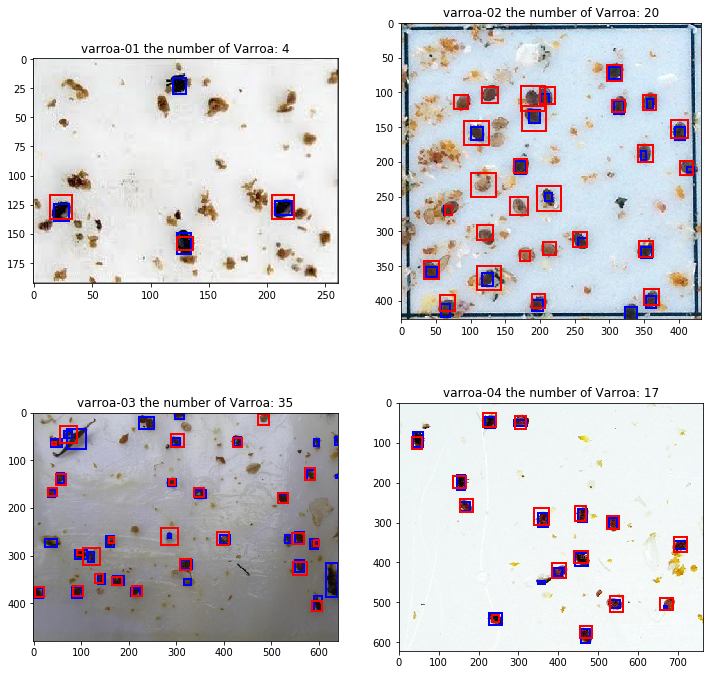

In [19]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm, annotations in zip(axes.ravel(), ic, im_names, annotations_xmls):
    # Iterate over annotations
    num, label_img = count_varroa(im)
    prop = skimage.measure.regionprops(label_img)
    for p in prop:
        rect = patches.Rectangle((p['bbox'][1], p['bbox'][0]), p['bbox'][3]-p['bbox'][1], p['bbox'][2]-p['bbox'][0],
                linewidth=2,edgecolor='b',facecolor='none')
        ax.add_patch(rect)
    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=2,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        
    ax.imshow(im)
    ax.set_title(nm+' the number of Varroa: %d'%(num))
plt.show()

### 2.3 IoU of the detected pattern w.r.t. the ground truth

Add your implementation and discussion

Hint: `skimage.measure.regionprops` implements a large variety of descriptors

For each predicted bounding box, we found the ground truth which has the largest IoU with the box. Besides, we also record the set $(i, j) = \arg\max_{i,j} IoU(A_i, B_j)$ of the ground truth and predicted bounding box to be used for the next question. If a predicted bounding box does not overlap any bounding box, the IoU will be zero and the ground truth in the set will be labeled as -1.

In [20]:
def iter_over_union(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3]) # intersection rectangle

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1) #the area of intersection rectangle

    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1) #the area of both the prediction and ground-truth

    iou = interArea / float(boxAArea + boxBArea - interArea) # the intersection over union 
    return iou

def cal_iou(label_img, annotations):
    gt_bboxes = []
    for anno in annotations:
        gt_bbox = list(anno['bbox'])
        gt_bbox[2] = gt_bbox[0] + gt_bbox[2]
        gt_bbox[3] = gt_bbox[1] + gt_bbox[3]
        gt_bboxes.append(gt_bbox) # transform the (x, y, width, heigth) to (x_min, y_min, x_max, y_max) for ground truth
    prop = skimage.measure.regionprops(label_img)
    ious = []
    gt_candidate_set = []
    for j, p in enumerate(prop):
        bbox = p['bbox']
        pre_bbox = (bbox[1], bbox[0], bbox[3]-1, bbox[2]-1) # tranform the (y_min, x_min,  y_max, x_max) to (x_min, y_min, x_max, y_max)
        iou = 0
        gt_i = -1 # -1 means the candinate not corresponding to any ground truth
        for i, gt_bbox in enumerate(gt_bboxes):
            new_iou = iter_over_union(gt_bbox, pre_bbox) # use the brute force method to calculate the largest IOU for each predicted box
            if new_iou > iou:
                iou = new_iou
                gt_i = i
        gt_candidate_set.append((gt_i,j))
        ious.append(iou)
    return ious,gt_candidate_set

In [21]:
for im, nm, annotations in zip(ic, im_names, annotations_xmls):
    # Iterate over annotations
    num, label_img = count_varroa(im)
    ious, gt_candidate_set = cal_iou(label_img, annotations)
    print('The IOUs for each predicted bounding box in '+nm+' are', end='')
    [print(' %.2f'%i, end='') for i in ious]
    print(end='')
    print('\nground truth and candidates set: ', gt_candidate_set)
    print('\n')

The IOUs for each predicted bounding box in varroa-01 are 0.00 0.40 0.42 0.60
ground truth and candidates set:  [(-1, 0), (1, 1), (0, 2), (2, 3)]


The IOUs for each predicted bounding box in varroa-02 are 0.55 0.29 0.29 0.61 0.23 0.25 0.33 0.18 0.63 0.16 0.09 0.79 0.31 0.48 0.38 0.21 0.35 0.41 0.24 0.00
ground truth and candidates set:  [(11, 0), (16, 1), (9, 2), (12, 3), (24, 4), (23, 5), (14, 6), (2, 7), (4, 8), (0, 9), (21, 10), (19, 11), (3, 12), (1, 13), (7, 14), (26, 15), (8, 16), (6, 17), (20, 18), (-1, 19)]


The IOUs for each predicted bounding box in varroa-03 are 0.00 0.00 0.26 0.16 0.60 0.00 0.31 0.00 0.19 0.54 0.56 0.00 0.68 0.55 0.66 0.87 0.71 0.05 0.00 0.50 0.33 0.00 0.33 0.35 0.21 0.62 0.43 0.00 0.62 0.66 0.00 0.74 0.57 0.51 0.63
ground truth and candidates set:  [(-1, 0), (-1, 1), (23, 2), (23, 3), (2, 4), (-1, 5), (14, 6), (-1, 7), (13, 8), (8, 9), (18, 10), (-1, 11), (6, 12), (9, 13), (3, 14), (0, 15), (22, 16), (24, 17), (-1, 18), (1, 19), (4, 20), (-1, 21), (16, 2

### 2.4 Precision, Recall and F1-score at two different IoU thresholds

Add your implementation and discussion

To calculate TP, FP, and FN, we need to use IoUs and the set  the set $(i, j) = \arg\max_{i,j} IoU(A_i, B_j)$. 

For TP, we count the number of predicted bounding boxes whose IoUs are larger than a threshold T. 

For FP, it is the number of the predicted bounding boxes which are classified as positive but it is actually negative. we count the number of predicted bounding boxes whose IoUs are below the threshold T.

For FN, it is the number of ground truth bounding boxes which are not predicted by our models. In other words, these ground truth bounding boxes overlap any predicted bounding box with the IOU below T.

Finally, we can use TP, FP, FN to calculate precision, recall, and F1-score.

In [22]:
def precision_recall_f1(T, ious,  gt_candidate_set, num_gt_bbox):
    # T is the threshols for true positive samples
    # ious is the list constaining all the ious
    # gt_candidate_set is the gt and candidate pair set
    # num_gt_bbox is the number of ground truth bbox
    total = len(ious)
    ious = np.array(ious)
    tp = np.sum(ious>T) # the number of true positive samples
    fp = np.sum(ious<=T) # the number of false positive samples
    
    gt_index = [] # use loop to fill the gt index in the list
    for iou, (i, j) in zip(ious.tolist(), gt_candidate_set):
        if (not i in gt_index) and (i!=-1) and (iou>=T):
            gt_index.append(i) # add the gt index that can correspond to our predicted bbox
    fn = num_gt_bbox - len(gt_index) # the number of false negative
    
    precision = tp / (tp+fp) if tp!=0 else 0
    recall = tp / (tp+fn) if tp!=0 else 0
    f1 = 2*precision*recall/(precision+recall) if precision*recall!=0 else 0
    
    print('tp', tp, 'fp', fp, 'fn', fn)
    return precision, recall, f1

In [23]:
T = 0.5
for im, nm, annotations in zip(ic, im_names, annotations_xmls):
    # Iterate over annotations
    num, label_img = count_varroa(im)
    ious, gt_candidate_set = cal_iou(label_img, annotations)
    precision, recall, f1 = precision_recall_f1(T, ious,  gt_candidate_set, len(annotations))
    print('The precision, recall, and F1 (T=0.5) for '+nm+' are %.2f, %.2f, and %.2f'%(precision, recall, f1))

print('\n')

T = 0.9
for im, nm, annotations in zip(ic, im_names, annotations_xmls):
    # Iterate over annotations
    num, label_img = count_varroa(im)
    ious, gt_candidate_set = cal_iou(label_img, annotations)
    precision, recall, f1 = precision_recall_f1(T, ious,  gt_candidate_set, len(annotations))
    print('The precision, recall, and F1 (T=0.9) for '+nm+' are %.2f, %.2f, and %.2f'%(precision, recall, f1))

tp 1 fp 3 fn 2
The precision, recall, and F1 (T=0.5) for varroa-01 are 0.25, 0.33, and 0.29
tp 4 fp 16 fn 23
The precision, recall, and F1 (T=0.5) for varroa-02 are 0.20, 0.15, and 0.17
tp 16 fp 19 fn 10
The precision, recall, and F1 (T=0.5) for varroa-03 are 0.46, 0.62, and 0.52
tp 7 fp 10 fn 8
The precision, recall, and F1 (T=0.5) for varroa-04 are 0.41, 0.47, and 0.44


tp 0 fp 4 fn 3
The precision, recall, and F1 (T=0.9) for varroa-01 are 0.00, 0.00, and 0.00
tp 0 fp 20 fn 27
The precision, recall, and F1 (T=0.9) for varroa-02 are 0.00, 0.00, and 0.00
tp 0 fp 35 fn 26
The precision, recall, and F1 (T=0.9) for varroa-03 are 0.00, 0.00, and 0.00
tp 0 fp 17 fn 15
The precision, recall, and F1 (T=0.9) for varroa-04 are 0.00, 0.00, and 0.00
